# Canny Edge Detector

In [18]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/ComputerVision')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


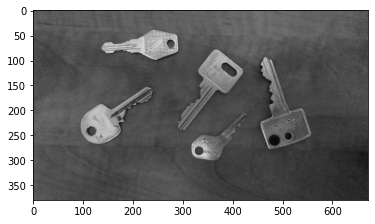

image.shape:  (380, 672)


In [19]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

img_org = cv2.imread("keys.png",0)
plt.imshow(img_org ,cmap='gray')
plt.show()
print('image.shape: ', img_org.shape)

## Step 1. Gaussian filter

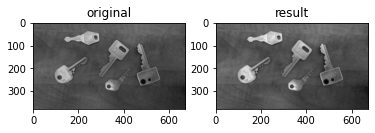

original shape: (380, 672)
gaussian shape: (380, 672)


In [20]:
def padding_img(img,k_size,style='constant'):
  x=img.shape[0]
  y=img.shape[1]
  new=np.zeros([x+2*k_size,y+2*k_size],np.uint8)
  for i in range(x):
    for j in range(y):
      new[i+k_size,j+k_size]=img[i,j]
  return new

def gaussian_kernel(size):
  sigma = 0.3*((size-1)*0.5 - 1) + 0.8
  Gaussian=[]
  total=0
  scope = np.linspace(-(size - 1)/2.,(size - 1)/2.,size)
  tmp = np.exp(-0.5 * np.square(scope)/np.square(sigma))
  Gaussian = np.outer(tmp, tmp)
  total = np.sum(Gaussian)
  return np.array(Gaussian)/total

KernelSize = 3
def Gaussian_Filter(KernelSize,image):
    row, col =image.shape
    Gaussian_Kernel = gaussian_kernel(KernelSize)

    resx=np.zeros((row,col),np.uint8)
    padimg = padding_img(image,(KernelSize-1)//2)

    for i in range(row):
      for j in range(col):
        t=0
        for x in range(KernelSize):
          for y in range(KernelSize):
            t+= padimg[i+x][j+y]*Gaussian_Kernel[x][y]
            resx[i][j]=t
    return resx.astype('int')

imgp = cv2.imread("keys.png",0)
ok = Gaussian_Filter(3,imgp)
plt.subplot(1,2,1)
plt.imshow(imgp,cmap='gray')
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(ok,cmap='gray')
plt.title('result')
plt.show()
print('original shape:',imgp.shape)
print('gaussian shape:',ok.shape)

## Step 2. Filter image with derivative of Gaussian

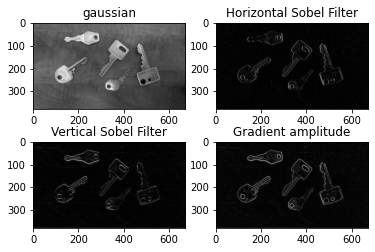

gaussian shape:  (380, 672)
Horizontal Sobel filter shape: (380, 672)
Vertical Sobel filter shape: (380, 672)
Gradient amplitude shape: (380, 672)


In [21]:
def pic_abs(img):
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      img[i,j]=abs(img[i,j])
  return img

def convol(image, kernel):
  Hi, Wi = image.shape
  Hk, Wk = kernel.shape
  out = np.zeros((Hi, Wi))
  pad_width0 = Hk // 2
  pad_width1 = Wk // 2
  pad_width = ((pad_width0,pad_width0),(pad_width1,pad_width1))
  padded = np.pad(image, pad_width, mode='edge')

  kernel = np.flip(np.flip(kernel, 0), 1)
  for i in range(Hi):
      for j in range(Wi):
          out[i, j] = np.sum(padded[i: i+Hk, j: j+Wk] * kernel)
  return out
def sobel(img):
  output = np.zeros(img.shape)
  angle = np.zeros(img.shape)
  horizontal = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  vertical = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

  Gx = convol(img,horizontal)
  Gy = convol(img,vertical)
  output = np.sqrt(Gx ** 2 + Gy ** 2)
  angle = (np.rad2deg(np.arctan2(Gy, Gx)) + 180) % 360
  Gx = pic_abs(Gx)
  Gy = pic_abs(Gy)
  return Gx, Gy, output, angle

hor,ver,grad,angle = sobel(ok)
hor = pic_abs(hor)
ver = pic_abs(ver)
plt.subplot(2,2,1)
plt.imshow(ok,cmap='gray')
plt.title('gaussian')
plt.subplot(2,2,2)
plt.imshow(hor,cmap='gray')
plt.title('Horizontal Sobel Filter')
plt.subplot(2,2,3)
plt.imshow(ver,cmap='gray')
plt.title('Vertical Sobel Filter')
plt.subplot(2,2,4)
plt.imshow(grad,cmap='gray')
plt.title('Gradient amplitude')
plt.show()
print('gaussian shape: ',ok.shape)
print('Horizontal Sobel filter shape:',hor.shape)
print('Vertical Sobel filter shape:',ver.shape)
print('Gradient amplitude shape:',grad.shape)

## Step 3. Non-maximum Suppression

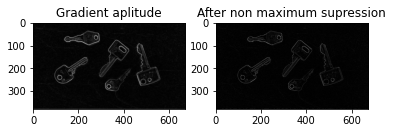

In [22]:
def non_maximum_suppression(gradient, angle):
  H, W = gradient.shape
  out = np.zeros((H, W))
  theta = np.floor((angle + 22.5) / 45) * 45
  for i in range(1, H-1):
    for j in range(1, W-1):
      alpha = np.deg2rad(theta[i, j])
      p1 = gradient[i-int(np.round(np.sin(alpha))), j-int(np.round(np.cos(alpha)))]
      p2 = gradient[i+int(np.round(np.sin(alpha))), j+int(np.round(np.cos(alpha)))]
      if not (gradient[i, j] >= p1 and gradient[i, j] >= p2):
        out[i, j] = 0
      else:
        out[i, j] = gradient[i, j]
  return out

After_non_maximum_supression = non_maximum_suppression(grad,angle)
plt.subplot(1,2,1)
plt.imshow(grad,cmap='gray')
plt.title('Gradient aplitude')
plt.subplot(1,2,2)
plt.imshow(After_non_maximum_supression,cmap='gray')
plt.title('After non maximum supression')
plt.show()

## Step 4. Thresholding edges

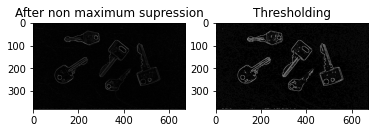

In [23]:
def seperate(img, minimum=60, maximum=180):
  M, N = img.shape
  out = np.zeros((M,N), dtype=np.int32)

  weak = np.int32(25)
  strong = np.int32(255)

  strong_i, strong_j = np.where(img >= maximum)
  zeros_i, zeros_j = np.where(img < minimum)
  weak_i, weak_j = np.where((img <= maximum) & (img >= minimum))

  out[strong_i, strong_j] = strong
  out[weak_i, weak_j] = weak

  return out
  
thresholding = seperate(After_non_maximum_supression,15,90)

plt.subplot(1,2,1)
plt.imshow(After_non_maximum_supression,cmap='gray')
plt.title('After non maximum supression')
plt.subplot(1,2,2)
plt.imshow(thresholding,cmap='gray')
plt.title('Thresholding')
plt.show()

## Step 5. Hysteresis

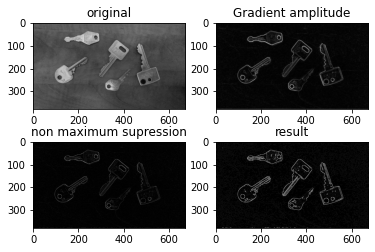

In [24]:
def Connect(img, weak):
  M, N = img.shape
  strong = 255  
  for i in range(1, M-1):
    for j in range(1, N-1):
        if (img[i,j] == weak):
          if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
            or (img[i, j-1] == strong) or (img[i, j+1] == strong)
            or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
            img[i, j] = strong
          else:
            img[i, j] = 0
  return img

result = Connect(thresholding,60)

plt.subplot(2,2,1)
plt.imshow(imgp,cmap='gray')
plt.title('original')
plt.subplot(2,2,2)
plt.imshow(grad,cmap='gray')
plt.title('Gradient amplitude')
plt.subplot(2,2,3)
plt.imshow(After_non_maximum_supression,cmap='gray')
plt.title('non maximum supression')
plt.subplot(2,2,4)
plt.imshow(result,cmap='gray')
plt.title('result')
plt.show()

# Canny Edge OpenCV 套件

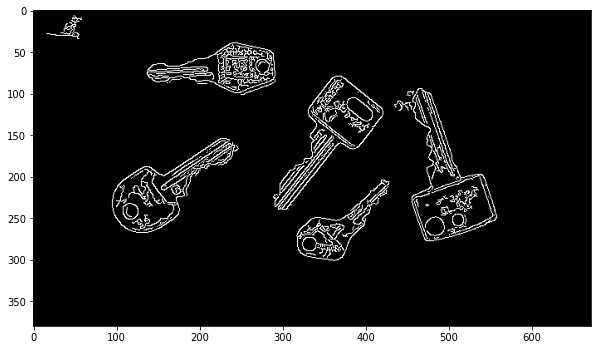

In [25]:
low_threshold = 15
high_threshold = 90
kernel_size = 3
#這邊較低的threshold用於檢測圖像中明顯的邊緣，較高的threshold則將間斷的邊緣連接起來。
plt.figure(figsize=(10,18))
img2 = cv2.imread("keys.png",0)
gray_blur = cv2.GaussianBlur(img2,(kernel_size, kernel_size),0)
edges = cv2.Canny(gray_blur, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')
plt.show()

# 加分討論 為什麼和套件不一樣

手刻的跟套件的有些許差別，手刻的對於雜訊的處理是比較乾淨的，如左上角手刻的是沒有顯示出雜訊的，但是手刻在鑰匙上面的紋路是比較弱的，連線起來看起來粗糙，套件的雖然左上角有雜訊，但是相對的鑰匙的紋路比較清楚。在手刻的程式中，有些紋路是很早就消失的，也有部分是被Thresholding硬生生地篩選掉了，所以根據手刻的結果以及套件結果，可以猜測以及推論有以下的不同
- 先從一開始的圖片讀入，套件以及手刻的應該是大同小異的內容，而有差的部分可能是在套件裡面有可能有smooth的function之類的，讓圖片在進行高斯濾波時能夠達到更不失真的效果
- 在NMS的步驟時，是以角度來做劃分的，在套件中有可能使用的是更為精確的算法或是用其他方式來補足
- 在Tresholding的步驟時，在手刻的情況是將兩個值都是寫死的，而在套件中的情況，可能會隨著情況，在某些部分會做一定比例的變動，讓效果可以更精確
- 在Hysteresis的步驟應該也是同Tresholding的情況相仿，有可能會是會根據先前運算完的結果來動態變化的，使得Connect起來更加精準
